# Kinetic energy time series

Computes and plots the volume-integrated kinetic energy over time for a set of four CESM2-MOM6 simulations.

In [1]:
import os
import sys
sys.path.insert(1,'/glade/u/home/yhoussam/analysis/mom6_diagnostics')
from analysis_mom6 import *
import matplotlib.pyplot as plt
import cmocean
from cartopy import crs as ccrs
from tqdm import tqdm
import colorcet as cc

data_path = '/glade/u/home/yhoussam/analysis/simulations/data/'
def return_ncfile_path(analysis_dir,sim,file):
    nc_dir = os.path.join(analysis_dir,sim)
    nc_dir = os.path.join(nc_dir,'ncfiles')
    file_name = sim+'_'+file+'.nc'
    path =  os.path.join(nc_dir,file_name)
    return path


import warnings
from xarray.coding.times import SerializationWarning

warnings.filterwarnings(
    "ignore",
    "Unable to decode time axis into full numpy.datetime64 objects",
    category=SerializationWarning
)


save_path = 'png/'
import matplotlib as mpl
mpl.rcParams['font.size'] = 20
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Load the data

In [2]:
case_names = ['gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.smag_control.003',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.MEKE_GM.004',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.MEKE_GM.007',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.leith_GM.028'
              ]
snames = ['REF','GM','GM+MBK','GM+LBK']


loc = 'archive'

sims = []
for i in range(len(snames)):
    sim = MOM6_simulation(snames[i],case_names[i],loc=loc)
    sims.append(sim)

num_sims = len(sims)

start_date = '0031-01-01'
end_date = '0061-12-31'
start_year = int(start_date[:4])
end_year = int(end_date[:4])

alpha_res = 2.
p_res = 50
def resolution(R,alpha,p):
    return 1./(1+(alpha*R)**p)


In [3]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
nw = 12

parallel = False
if nw > 1:
    parallel = True
    cluster = NCARCluster(interface='ext',project='P93300012',walltime='02:00:00')
    cluster.scale(nw)
    client = Client(cluster)

/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/

In [7]:
%%time
for sim in sims:
    sim.open_all_files(sim.z_path)
    sim.open_grid()

Opened all files
Opened grid and assigned coordinates.
Opened all files
Opened grid and assigned coordinates.
Opened all files
Opened grid and assigned coordinates.
Opened all files
Opened grid and assigned coordinates.
CPU times: user 1min, sys: 5.17 s, total: 1min 5s
Wall time: 2min 12s


### Compute the volume-integrate kinetic energy

In [6]:
def global_mean_KE(ds,z_min=None,z_max=None):
    ds = ds#.sel(z_l=slice(0, 100))
    if z_min is not None or z_max is not None:
        ds = ds.sel(z_l=slice(z_min,z_max))
    num = (ds.KE.fillna(0.) * ds['volcello'].fillna(0.)).sum(dim=['xh', 'yh', 'z_l'])
    denom = (ds['volcello'].fillna(0.)).sum(dim=['xh', 'yh', 'z_l'])
    return num / denom

In [7]:
%%time
ke_sums = []
for sim in sims:
    ke_sum = global_mean_KE(sim.ds).compute()
    ke_sums.append(ke_sum)

CPU times: user 55.8 s, sys: 2.33 s, total: 58.2 s
Wall time: 4min 56s


In [4]:
import pickle
save = 0
if save:
    results = {
        'ke_sums': ke_sums,
    }
    
    with open('Kinetic_Energy_Volume.pkl', 'wb') as f:
        pickle.dump(results, f, protocol=4)
else:
    with open('Kinetic_Energy_Volume.pkl', 'rb') as f:
        results = pickle.load(f)
    
    ke_sums   = results['ke_sums']

### Plot the volume-integrated kinetic energy

CPU times: user 312 ms, sys: 24.2 ms, total: 336 ms
Wall time: 958 ms


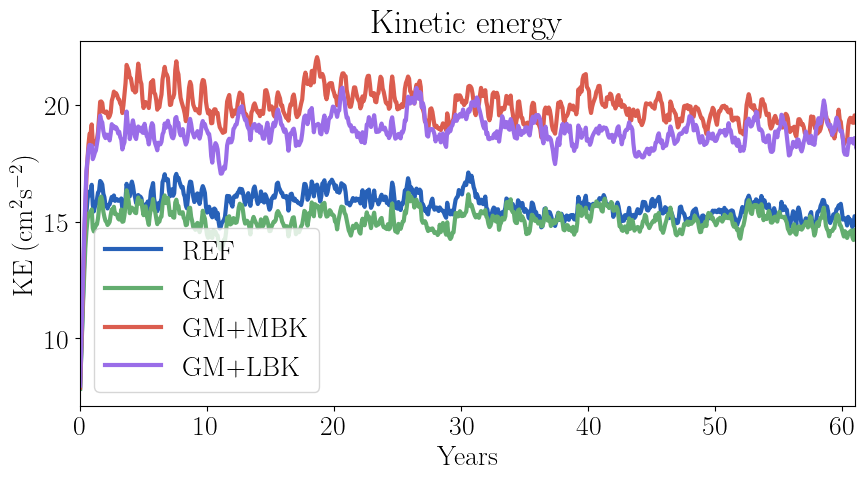

In [8]:
%%time
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
c = np.array([[39, 97, 184],  # Blue
              [99, 173, 111],   # Green
              [219, 93, 79],   # Red
              [154, 109, 232],  # Purple
              [255, 200, 61] ],  # Yellow], 
             dtype=np.float64) / 255.0  # Normalize to 0-1 scale

for i in range(num_sims):
    field = ke_sums[i] * (100)**2
    sim = sims[i]
    # Convert time coordinate to days
    days = (sim.ds.time - sim.ds.time[0]).astype('timedelta64').astype(float)
    days /= (1e9*3600*24*365.25)
    ## Start the control run at year 50. (bs run start at year 60!)
    ax.plot(days, field, label=snames[i],c=c[i],lw=3)

ax.set_xlabel('Years')
ax.set_ylabel(r'KE ($\mathrm{cm}^2 \mathrm{s}^{-2}$)')
title = 'Kinetic energy'
ax.set_title(title)
#ax.set_ylim([0.0e18, 5.0e18])
ax.set_xlim([0, 61])

ax.tick_params(axis='both', which='major')
#ax.tick_params(axis='both', which='minor', labelsize=8)

ax.legend(loc='best')
plt.subplots_adjust(bottom=0.15)
#ax.grid()
plt.savefig(save_path+title+'legend.png',dpi=300)

CPU times: user 265 ms, sys: 7.65 ms, total: 272 ms
Wall time: 595 ms


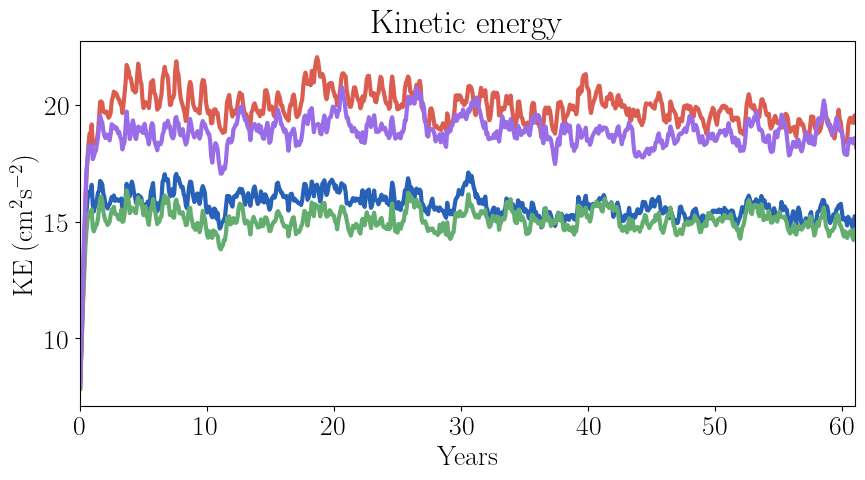

In [9]:
%%time
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
c = np.array([[39, 97, 184],  # Blue
              [99, 173, 111],   # Green
              [219, 93, 79],   # Red
              [154, 109, 232],  # Purple
              [255, 200, 61] ],  # Yellow], 
             dtype=np.float64) / 255.0  # Normalize to 0-1 scale

for i in range(num_sims):
    field = ke_sums[i] * (100)**2
    sim = sims[i]
    # Convert time coordinate to days
    days = (sim.ds.time - sim.ds.time[0]).astype('timedelta64').astype(float)
    days /= (1e9*3600*24*365.25)
    ## Start the control run at year 50. (bs run start at year 60!)
    ax.plot(days, field, label=snames[i],c=c[i],lw=3)

ax.set_xlabel('Years')
ax.set_ylabel(r'KE ($\mathrm{cm}^2 \mathrm{s}^{-2}$)')
title = 'Kinetic energy'
ax.set_title(title)
#ax.set_ylim([0.0e18, 5.0e18])
ax.set_xlim([0, 61])

ax.tick_params(axis='both', which='major')
#ax.tick_params(axis='both', which='minor', labelsize=8)

#ax.legend(loc='best')
#ax.grid()
plt.subplots_adjust(bottom=0.15)
plt.savefig(save_path+title+'n0_legend.png',dpi=300)

In [23]:
ke0 = ke_sums[0][372:].mean().values* (100)**2

for i in range(4):
    ke = ke_sums[i][372:].mean().values* (100)**2
    print(sims[i].short_name +f":\t {ke:.2f} \t {ke/ke0:.2f}")

REF:	 15.44 	 1.00
GM:	 15.05 	 0.97
GM+MBK:	 19.66 	 1.27
GM+LBK:	 18.75 	 1.21
